<a href="https://colab.research.google.com/github/Arna-S/Hello-World/blob/main/IANNWTF20_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
ds, info = tfds.load('genomics_ood', with_info=True, as_supervised=True)

In [ ]:
# print(info)

In [ ]:
ds

{'test': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 'test_ood': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 'train': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 'validation': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>,
 'validation_ood': <PrefetchDataset shapes: ((), ()), types: (tf.string, tf.int64)>}

In [ ]:
train_data, test_data = ds["train"], ds["test"]

In [ ]:
# shuffel and create batches of training data
train_data = train_data.take(100000)
train_data = train_data.shuffle(10000)
train_data = train_data.batch(256)

test_data = test_data.take(1000)
test_data = test_data.batch(256)


In [ ]:
# count number of batches in one epoch
count = 0
for batch in train_data:
    count+=1
print(count)

391


In [ ]:
# check data

for batch in train_data:
    print(batch[0][0])   # input
    print(batch[1][0])   # label
    # print((batch['seq'].shape, batch['label']))
    # for input_seq in batch['seq']:
        # print(input_seq)
        # break
    break

tf.Tensor(b'GTATAGCCCGCCCAGCGACCAATGGCTTTATCGGCATAGGTGGAAAACGAACCGGTATCGGGCGTGGCAACCGCCATTTCCGCCAACATCCGCATAATCATAACCACCAGTAATCCGGCGAACAGATAGGCCAGTAATACCGCCGGGCCCGCTTCGGCGATGGCGACGCTGGAACCGACAAACAGACTTGCGCCGATAACACCGGCAATAGACAACATGGTGACGTGGCGTGACTTCAGCCCGCCGCCTA', shape=(), dtype=string)
tf.Tensor(3, shape=(), dtype=int64)


In [ ]:
batch[0][0].numpy()

b'GTATAGCCCGCCCAGCGACCAATGGCTTTATCGGCATAGGTGGAAAACGAACCGGTATCGGGCGTGGCAACCGCCATTTCCGCCAACATCCGCATAATCATAACCACCAGTAATCCGGCGAACAGATAGGCCAGTAATACCGCCGGGCCCGCTTCGGCGATGGCGACGCTGGAACCGACAAACAGACTTGCGCCGATAACACCGGCAATAGACAACATGGTGACGTGGCGTGACTTCAGCCCGCCGCCTA'

In [ ]:
# def get_onehot_encoding(input_seq_batch):
#     vocab_encoding = {'A':0, 'C':1, 'G':2, 'T':3}
#     tensor_batch = []
#     for input_seq in input_seq_batch:
#         tensor = []
#         input_seq.numpy().decode("utf-8")
#         for genome in input_seq.numpy().decode("utf-8"):
#             # concatinate all onehot of nucleotidesz
#             tensor.extend(tf.one_hot(vocab_encoding[genome], 4).numpy())
#         tensor_batch.append(tensor)
#     return tf.constant(tensor_batch)


In [ ]:
# %%timeit
# # check get_onehot_encoding method:
# for batch in train_data:
#     X = get_onehot_encoding(batch[0])
#     print(X.shape)
#     break

In [ ]:
# def get_onehot_encoding(input_seq_batch):
#     vocab_encoding = {'A':0, 'C':1, 'G':2, 'T':3}
#     tensor_batch = None
#     for input_seq in input_seq_batch:
#         tensor = np.zeros(0)
#         input_seq.numpy().decode("utf-8")
#         for genome in input_seq.numpy().decode("utf-8"):
#             # concatinate all onehot of nucleotidesz
#             tensor = np.concatenate((tensor, tf.one_hot(vocab_encoding[genome], 4).numpy()))            
#         if tensor_batch is None:
#             tensor_batch = tensor
#         else:
#             tensor_batch = np.vstack((tensor_batch, tensor))
#     return tf.constant(tensor_batch)

In [ ]:
# %%timeit
# # check get_onehot_encoding method:
# for batch in train_data:
#     X = get_onehot_encoding(batch[0])
#     print(X.shape)
#     break

In [ ]:
def onehotify(input_seq_batch):
    vocab = {'A': '0', 'C': '1', 'G': '2', 'T': '3'}
    tensor_batch = None
    for tensor in input_seq_batch:
        for key in vocab.keys():
            tensor = tf.strings.regex_replace(tensor, key, vocab[key])
        split = tf.strings.bytes_split(tensor)
        labels = tf.cast(tf.strings.to_number(split), tf.uint8)
        onehot = tf.one_hot(labels, 4)
        onehot = tf.reshape(onehot, (-1,))
        
        if tensor_batch is None:
            tensor_batch = onehot.numpy()
        else:
            tensor_batch = np.vstack((tensor_batch, onehot.numpy()))
    
    return tensor_batch

In [ ]:
%%timeit
# check get_onehot_encoding method:
for batch in train_data:
    X = onehotify(batch[0])
    print(X.shape)
    break

(256, 1000)
(256, 1000)
(256, 1000)
(256, 1000)
(256, 1000)
(256, 1000)
(256, 1000)
(256, 1000)
796 ms ± 46.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super().__init__()

        # Hidden layer
        self.hidden1 = tf.keras.layers.Dense(units=256, activation=tf.nn.sigmoid)
        self.hidden2 = tf.keras.layers.Dense(units=256, activation=tf.nn.sigmoid,)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    
    # Define the forward propagation of the model, that is, how to return the
    # required model output based on the input `X`
    def call(self, X):
        X = self.hidden1(X)
        X = self.hidden2(X)
        return self.out(X)
        

In [ ]:
# initialize model
model = MyModel()

In [ ]:
# initialize the model:
for batch in train_data:
    # print((batch['seq'].shape, batch['label']))
    X = onehotify(batch[0])
    model(X)
    break

In [ ]:
# model hyper parameters:
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

In [ ]:
# training step

epochs = 5

# Initialize lists for later visualiztion
train_steps = []
train_losses = []
train_accuracies = []
test_steps = []
test_losses = []
test_accuracies = []
step = 0


for epoch in range(epochs):
    print(f"Epoch number: {epoch}")
    for batch in train_data:
        if step%10==0: print(".",end="") # to print progress of training
        X = batch[0]
        # get one hot encoding of input
        X = onehotify(X)
        
        target = batch[1]
        # get onehot encoding for label
        target = tf.one_hot(target, depth = 10)

        # training step
        with tf.GradientTape() as tape:
            y_hat = model(X)
            loss = cross_entropy_loss(target, y_hat)
        params = model.trainable_variables
        grads = tape.gradient(loss, params)

        # updates weights:
        optimizer.apply_gradients(zip(grads, params))
        
        
        # training accuracy calculations
        if step % 25 == 0:
            # Compute the accuracy.
            accuracy = np.sum(np.argmax(target, axis=1) == np.argmax(y_hat, axis=1)) / target.shape[0]
            # Store loss and accuracy.
            train_steps.append(step)
            train_accuracies.append(accuracy)
            train_losses.append(loss)
            
        # Calculate the test loss and accuracy every 50 steps.
        if step % 50 == 0:
            for (x,t) in test_data:
                # Compute loss and accuracy for the test data.
                t = tf.reshape(t, shape=[-1])
                t = tf.one_hot(t.numpy(), 10)
                x = onehotify(x)
                output = model(x)
                loss = cross_entropy_loss(t, output)
                accuracy = np.sum(np.argmax(t, axis=1) == np.argmax(output, axis=1)) / t.shape[0]
                ######################
                test_steps.append(step)
                test_accuracies.append(accuracy)
                test_losses.append(loss)

        step+=1
    print()

Epoch number: 0
........................................
Epoch number: 1
.......................................
Epoch number: 2
.......................................
Epoch number: 3
.......................................
Epoch number: 4
.......................................


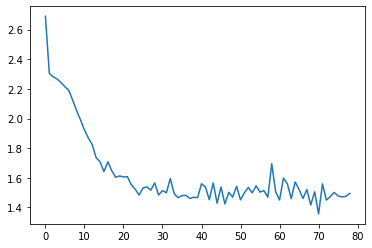

In [ ]:
plt.plot(train_losses)
plt.show()

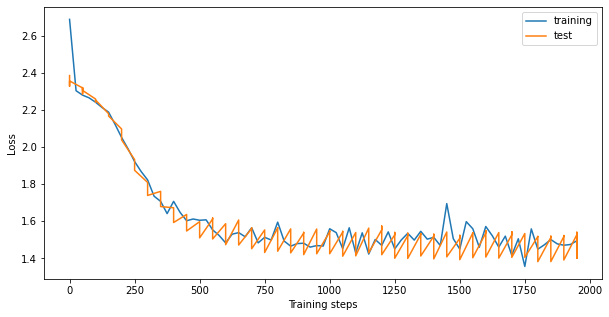

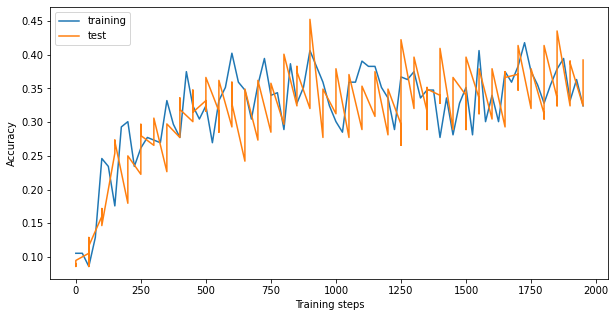

In [ ]:
### YOUR CODE HERE ###
plt.figure(figsize=(10,5))
line1, = plt.plot(train_steps, train_losses)
line2, = plt.plot(test_steps, test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure(figsize=(10,5))
line1, = plt.plot(train_steps, train_accuracies)
line2, = plt.plot(test_steps, test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.legend((line1,line2),("training","test"))
plt.show()

In [ ]:
print(f"Test Accuracy: {test_accuracies[-1]}")

Test Accuracy: 0.3922413793103448
